Human gene research is moving fast. How do you summarize all of these discoveries in an objective way so they can be used in the nutrition (nutrigenomics) or healthcare fields?  How do you gather enough evidence to point the way toward needed medical research? 

Using gene definitions and abstracts from NCBI, I'd like to make a gene calculator that knows the language of gene research and can tell you which genes are most related to a health disorder. There are so many conditions for which the medical field has no answers, and that means diet and nutrition are an important aspect of quality of life improvement. Gene mutations often have very specific roles in metabolism and understanding these roles can lead the way to better health.


Using gene technical definitions and abstracts containing both gene and medical information from the NCBI website, I'm going to use Word2Vec similarity to match gene abbreviations with medical disorders. First I'll create a dataframe with tokenized strings. I'll use lemmas but i'll keep stop words. Then I'll run the Word2Vec model and see if I can match gene acronyms to diseases with varied number of mentions in the dataset. I'll look at the top 10 matches for my analysis and see if the disease keyword is mentioned. I'll optimize model parameters by running the training model many times using np.random and adjusting the model parameters to find the best matches each time.

In [71]:
import pandas as pd
import numpy as np
from sklearn.cluster import AffinityPropagation as Aff
import numpy as np
#import distance
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [72]:
import spacy

First I'll import and clean my datasets.

In [73]:
#import,clean and label datasets
abstracts= pd.read_csv('genesdf')
abstracts.head()

,Unnamed: 0,symbol,blurb,match
0,0,TP53,This gene encodes a tumor suppressor protein c...,0
1,1,EGFR,The protein encoded by this gene is a transmem...,0
2,2,TNF,This gene encodes a multifunctional proinflamm...,0
3,3,APOE,The protein encoded by this gene is a major ap...,0
4,4,VEGFA,This gene is a member of the PDGF/VEGF growth ...,0


In [74]:
abstracts['abstract'] = 1

In [75]:
genes2 = pd.read_csv('genesdf2')
genes2['med']=0
genes2['abstract'] = 0
genes2.head()

,Unnamed: 0,acros,blurb2,match,med,abstract
0,0,TP53,Official Symbol- TP53 and Name: tumor protein ...,0,0,0
1,1,EGFR,Official Symbol- EGFR and Name: epidermal grow...,0,0,0
2,2,TNF,Official Symbol- TNF and Name: tumor necrosis ...,0,0,0
3,3,APOE,Official Symbol- APOE and Name: apolipoprotein...,0,0,0
4,4,VEGFA,Official Symbol- VEGFA and Name: vascular endo...,0,0,0


In [76]:
genes2['symbols'] = genes2['acros'].apply(lambda x: (str(x).upper()).strip())
genes2 = genes2.drop(['acros','Unnamed: 0'],axis=1)

In [77]:
genes2[genes2['symbols']=='APP']

,blurb2,match,med,abstract,symbols
12,Official Symbol- APP and Name: amyloid beta pr...,0,0,0,APP
3068,Official Symbol- APP and Name: amyloid beta pr...,1,0,0,APP


In [78]:
genes3 = genes2.drop_duplicates(subset=['blurb2','symbols'], keep='first', inplace=False)
genes3[genes3['symbols']=='APP']

,blurb2,match,med,abstract,symbols
12,Official Symbol- APP and Name: amyloid beta pr...,0,0,0,APP


In [79]:
abstracts['med']=0
abstracts.head()

,Unnamed: 0,symbol,blurb,match,abstract,med
0,0,TP53,This gene encodes a tumor suppressor protein c...,0,1,0
1,1,EGFR,The protein encoded by this gene is a transmem...,0,1,0
2,2,TNF,This gene encodes a multifunctional proinflamm...,0,1,0
3,3,APOE,The protein encoded by this gene is a major ap...,0,1,0
4,4,VEGFA,This gene is a member of the PDGF/VEGF growth ...,0,1,0


In [80]:
abstracts['symbols'] = abstracts['symbol'].apply(lambda x: (str(x).upper().strip()))
abstracts.drop(['symbol'],axis=1,inplace=True)

In [81]:
#Add acronym to abstracts text
abstracts['blurbs'] = abstracts['symbols'].map(str) +','+abstracts['blurb'].map(str)
abstracts.head()

,Unnamed: 0,blurb,match,abstract,med,symbols,blurbs
0,0,This gene encodes a tumor suppressor protein c...,0,1,0,TP53,"TP53,This gene encodes a tumor suppressor prot..."
1,1,The protein encoded by this gene is a transmem...,0,1,0,EGFR,"EGFR,The protein encoded by this gene is a tra..."
2,2,This gene encodes a multifunctional proinflamm...,0,1,0,TNF,"TNF,This gene encodes a multifunctional proinf..."
3,3,The protein encoded by this gene is a major ap...,0,1,0,APOE,"APOE,The protein encoded by this gene is a maj..."
4,4,This gene is a member of the PDGF/VEGF growth ...,0,1,0,VEGFA,"VEGFA,This gene is a member of the PDGF/VEGF g..."


In [82]:
abstracts['blurbs2'] = abstracts['blurbs'].apply(lambda x: str(x).split(',',1))
abstracts.head()

,Unnamed: 0,blurb,match,abstract,med,symbols,blurbs,blurbs2
0,0,This gene encodes a tumor suppressor protein c...,0,1,0,TP53,"TP53,This gene encodes a tumor suppressor prot...","[TP53, This gene encodes a tumor suppressor pr..."
1,1,The protein encoded by this gene is a transmem...,0,1,0,EGFR,"EGFR,The protein encoded by this gene is a tra...","[EGFR, The protein encoded by this gene is a t..."
2,2,This gene encodes a multifunctional proinflamm...,0,1,0,TNF,"TNF,This gene encodes a multifunctional proinf...","[TNF, This gene encodes a multifunctional proi..."
3,3,The protein encoded by this gene is a major ap...,0,1,0,APOE,"APOE,The protein encoded by this gene is a maj...","[APOE, The protein encoded by this gene is a m..."
4,4,This gene is a member of the PDGF/VEGF growth ...,0,1,0,VEGFA,"VEGFA,This gene is a member of the PDGF/VEGF g...","[VEGFA, This gene is a member of the PDGF/VEGF..."


In [83]:
def add_symbol(words_list,replace,texts):
    for words in words_list:
        new = texts.replace(words,replace)
        texts = new
    return texts
   

In [84]:
abstracts['blurbs3'] = abstracts['blurbs2'].apply(lambda x: add_symbol(['This gene','this gene'],x[0]+' gene',x[1]) if len(x)==2 else np.nan)

In [85]:
abstracts.head()

,Unnamed: 0,blurb,match,abstract,med,symbols,blurbs,blurbs2,blurbs3
0,0,This gene encodes a tumor suppressor protein c...,0,1,0,TP53,"TP53,This gene encodes a tumor suppressor prot...","[TP53, This gene encodes a tumor suppressor pr...",TP53 gene encodes a tumor suppressor protein c...
1,1,The protein encoded by this gene is a transmem...,0,1,0,EGFR,"EGFR,The protein encoded by this gene is a tra...","[EGFR, The protein encoded by this gene is a t...",The protein encoded by EGFR gene is a transmem...
2,2,This gene encodes a multifunctional proinflamm...,0,1,0,TNF,"TNF,This gene encodes a multifunctional proinf...","[TNF, This gene encodes a multifunctional proi...",TNF gene encodes a multifunctional proinflamma...
3,3,The protein encoded by this gene is a major ap...,0,1,0,APOE,"APOE,The protein encoded by this gene is a maj...","[APOE, The protein encoded by this gene is a m...",The protein encoded by APOE gene is a major ap...
4,4,This gene is a member of the PDGF/VEGF growth ...,0,1,0,VEGFA,"VEGFA,This gene is a member of the PDGF/VEGF g...","[VEGFA, This gene is a member of the PDGF/VEGF...",VEGFA gene is a member of the PDGF/VEGF growth...


In [86]:
#prepare to combine datasets
abstracts = abstracts.drop(['blurb','blurbs','blurbs2'],axis=1)
abstracts.head()

,Unnamed: 0,match,abstract,med,symbols,blurbs3
0,0,0,1,0,TP53,TP53 gene encodes a tumor suppressor protein c...
1,1,0,1,0,EGFR,The protein encoded by EGFR gene is a transmem...
2,2,0,1,0,TNF,TNF gene encodes a multifunctional proinflamma...
3,3,0,1,0,APOE,The protein encoded by APOE gene is a major ap...
4,4,0,1,0,VEGFA,VEGFA gene is a member of the PDGF/VEGF growth...


In [87]:
abstracts.drop(['abstract','med','Unnamed: 0',],axis=1,inplace=True)
abstracts.rename(columns={'blurbs3':'blurb2'},inplace=True)
abstracts

,match,symbols,blurb2
0,0,TP53,TP53 gene encodes a tumor suppressor protein c...
1,0,EGFR,The protein encoded by EGFR gene is a transmem...
2,0,TNF,TNF gene encodes a multifunctional proinflamma...
3,0,APOE,The protein encoded by APOE gene is a major ap...
4,0,VEGFA,VEGFA gene is a member of the PDGF/VEGF growth...
...,...,...,...
1287,1,NR1I2,NR1I2 gene product belongs to the nuclear rece...
1288,1,ABCG2,The membrane-associated protein encoded by ABC...
1289,1,CRP,[More information is available at EcoCyc: EG10...
1290,1,RPOB,HT_Cmplx11_Mem: [More information is available...


Next I'll combine the gene abstracts and gene definitions into one dataframe.

In [88]:
genes4=pd.DataFrame(genes3[['match','symbols','blurb2']])
genes4

,match,symbols,blurb2
0,0,TP53,Official Symbol- TP53 and Name: tumor protein ...
1,0,EGFR,Official Symbol- EGFR and Name: epidermal grow...
2,0,TNF,Official Symbol- TNF and Name: tumor necrosis ...
3,0,APOE,Official Symbol- APOE and Name: apolipoprotein...
4,0,VEGFA,Official Symbol- VEGFA and Name: vascular endo...
...,...,...,...
3241,1,KDRL,Official Symbol- kdrl and Name: kinase insert ...
3244,1,CRH,Official Symbol- Crh and Name: corticotropin r...
3248,1,CRP,"cAMP-activated global transcription factor, me..."
3249,1,RPOB,"RNA polymerase, beta subunit [Escherichia coli..."


In [89]:
genes4.shape

(3094, 3)

In [90]:
#Combine datasets and clean the data more
genes = genes4.append(abstracts,ignore_index=True)


In [91]:
genes.head()

,match,symbols,blurb2
0,0,TP53,Official Symbol- TP53 and Name: tumor protein ...
1,0,EGFR,Official Symbol- EGFR and Name: epidermal grow...
2,0,TNF,Official Symbol- TNF and Name: tumor necrosis ...
3,0,APOE,Official Symbol- APOE and Name: apolipoprotein...
4,0,VEGFA,Official Symbol- VEGFA and Name: vascular endo...


In [92]:
genes[genes['symbols']=='APP']

,match,symbols,blurb2
12,0,APP,Official Symbol- APP and Name: amyloid beta pr...
3106,0,APP,APP gene encodes a cell surface receptor and t...
4231,1,APP,APP gene encodes a cell surface receptor and t...


In [93]:
genes['blurb3'] = genes['blurb2'].apply(lambda x: str(x).replace('Official Symbol-',''))

In [94]:
genes['blurb4'] = genes['blurb3'].apply(lambda x: str(x).replace('and Name:','is'))

In [95]:
genes['blurb5'] = genes['blurb4'].apply(lambda x: str(x).replace('Other Aliases:','also'))

In [96]:
genes['blurb6'] = genes['blurb5'].apply(lambda x: str(x).replace('Other Designations:','It is'))

In [97]:
genes['blurb7'] = genes['blurb6'].apply(lambda x: str(x).replace('[Homo sapiens (human)]','(human)'))

In [98]:
genes['blurb8'] = genes['blurb7'].apply(lambda x: str(x).replace('Other Aliases-','and'))

In [99]:
genes = genes.drop(columns = ['blurb2','blurb3','blurb4','blurb5','blurb6','blurb7'])

In [100]:
genes.head()

,match,symbols,blurb8
0,0,TP53,"TP53 is tumor protein p53 (human),also BCC7, ..."
1,0,EGFR,EGFR is epidermal growth factor receptor (hum...
2,0,TNF,"TNF is tumor necrosis factor (human),also DIF..."
3,0,APOE,"APOE is apolipoprotein E (human),also AD2, AP..."
4,0,VEGFA,VEGFA is vascular endothelial growth factor A...


In [101]:
genes.sort_values(['match'],ascending=False,inplace=True)
genes.head()

,match,symbols,blurb8
4385,1,CDH1,CDH1 gene encodes a classical cadherin of the ...
3072,1,SOD1,Sod1 is Superoxide dismutase 1 [Drosophila me...
3074,1,RPR,rpr is reaper [Drosophila melanogaster (fruit...
3075,1,NAN,"121. LTA, LTA is lymphotoxin alpha (human),als..."
3076,1,HB,hb is hunchback [Drosophila melanogaster (fru...


In [102]:
genes.shape

(4386, 3)

In [103]:
genes.drop_duplicates(subset=['symbols','blurb8'], keep='first', inplace=True)
genes.shape

(4226, 3)

In [104]:
genes.head()

,match,symbols,blurb8
4385,1,CDH1,CDH1 gene encodes a classical cadherin of the ...
3072,1,SOD1,Sod1 is Superoxide dismutase 1 [Drosophila me...
3074,1,RPR,rpr is reaper [Drosophila melanogaster (fruit...
3075,1,NAN,"121. LTA, LTA is lymphotoxin alpha (human),als..."
3076,1,HB,hb is hunchback [Drosophila melanogaster (fru...


Next I'll tokenize the data and make lemmas.

In [105]:
#Tokenize data and make lemmas
import spacy

nlp = spacy.load('en_core_web_sm')

In [106]:
genes['tokens'] = genes['blurb8'].apply(lambda x: nlp(x))

In [107]:
genes['lemmas'] = genes['tokens'].apply(lambda x: [token.lemma_ for token in x])

In [108]:
genes.head()

,match,symbols,blurb8,tokens,lemmas
4385,1,CDH1,CDH1 gene encodes a classical cadherin of the ...,"(CDH1, gene, encodes, a, classical, cadherin, ...","[CDH1, gene, encode, a, classical, cadherin, o..."
3072,1,SOD1,Sod1 is Superoxide dismutase 1 [Drosophila me...,"( , Sod1, is, Superoxide, dismutase, 1, [, Dro...","[ , Sod1, be, Superoxide, dismutase, 1, [, Dro..."
3074,1,RPR,rpr is reaper [Drosophila melanogaster (fruit...,"( , rpr, is, reaper, [, Drosophila, melanogast...","[ , rpr, be, reaper, [, Drosophila, melanogast..."
3075,1,NAN,"121. LTA, LTA is lymphotoxin alpha (human),als...","(121, ., LTA, ,, LTA, is, lymphotoxin, alpha, ...","[121, ., LTA, ,, LTA, be, lymphotoxin, alpha, ..."
3076,1,HB,hb is hunchback [Drosophila melanogaster (fru...,"( , hb, is, hunchback, [, Drosophila, melanoga...","[ , hb, be, hunchback, [, Drosophila, melanoga..."


In [109]:
genes.shape

(4226, 5)

In [110]:
genes.dropna(subset=['symbols','blurb8'],inplace=True)
genes.shape

(4226, 5)

I'll prepare the training and test sets in a way that makes sure both sets have matching definitions and abstracts.

In [111]:
genes_match = genes[genes['match']==1]
genes_no = genes[genes['match']==0]
genes_match.shape

(453, 5)

In [112]:
import gensim
from gensim.models import word2vec

In [113]:
msk = np.random.rand(len(genes_match)) < 0.8
trainM = genes_match[msk]
testM = genes_match[~msk]
msk = np.random.rand(len(genes_no)) < 0.8
train = genes_no[msk]
test = genes_no[~msk]
train = train.append(trainM,ignore_index = True)
test = test.append(testM,ignore_index = True)


Because my training and test sets were prepared using np.random, I was able to optimize my model parameters by examining the success of  multiple versions of the training model. My final word2vec model uses CBOW with a window of 28, and a word vector length of 95.

In [114]:
train['disorder'] = np.where((train['blurb8'].str.contains('alzheimer|parkinson|dystrophy|ehlers|cancer|leukemia|diabetes',case=False)),1,0)
train['alzheimer'] = np.where((train['blurb8'].str.contains('alzheimer',case=False)),1,0)
train['disorder'].value_counts()
abbrev = pd.DataFrame(train[train['disorder']==1])
abbrev.head()

,match,symbols,blurb8,tokens,lemmas,disorder,alzheimer
21,0,MAGEA3,"MAGEA3 is MAGE family member A3 (human),also ...","( , MAGEA3, is, MAGE, family, member, A3, (, h...","[ , magea3, be, MAGE, family, member, a3, (, h...",1,0
41,0,NAN,"61. LIFR, LIFR is LIF receptor alpha (human),a...","(61, ., LIFR, ,, LIFR, is, LIF, receptor, alph...","[61, ., lifr, ,, LIFR, be, lif, receptor, alph...",1,0
70,0,NAN,"61. SUMO4, SUMO4 is small ubiquitin-like modif...","(61, ., SUMO4, ,, SUMO4, is, small, ubiquitin,...","[61, ., SUMO4, ,, SUMO4, be, small, ubiquitin,...",1,0
75,0,IL13RA2,IL13RA2 is interleukin 13 receptor subunit al...,"( , IL13RA2, is, interleukin, 13, receptor, su...","[ , IL13RA2, be, interleukin, 13, receptor, su...",1,0
111,0,MCM3,MCM3 is minichromosome maintenance complex co...,"( , MCM3, is, minichromosome, maintenance, com...","[ , MCM3, be, minichromosome, maintenance, com...",1,0


I tested the success of my model by looking at model.wv.similarity between gene abbrevitions and disorders. Results are below.

In [115]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    np.asarray(train['lemmas']),
    workers=4,     # Number of threads to run in parallel 
    min_count=1,  # Minimum word count threshold.
    window=28,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=105,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [116]:
vocab = model.wv.vocab.keys()

In [117]:
# 1 is a perfect match and 0 is no similarity
print(model.wv.similarity('disease', 'syndrome'))

 

0.76235294


The model found a strong similarity between 'disease' and 'syndrome' which is correct, so I decided to test the disease similarities.

In [118]:
train.head()

,match,symbols,blurb8,tokens,lemmas,disorder,alzheimer
0,0,AMFR,AMFR is autocrine motility factor receptor (h...,"( , AMFR, is, autocrine, motility, factor, rec...","[ , AMFR, be, autocrine, motility, factor, rec...",0,0
1,0,NCR3,NCR3 is natural cytotoxicity triggering recep...,"( , NCR3, is, natural, cytotoxicity, triggerin...","[ , NCR3, be, natural, cytotoxicity, trigger, ...",0,0
2,0,GNA13,"GNA13 is G protein subunit alpha 13 (human),a...","( , GNA13, is, G, protein, subunit, alpha, 13,...","[ , GNA13, be, G, protein, subunit, alpha, 13,...",0,0
3,0,STXBP1,"STXBP1 is syntaxin binding protein 1 (human),...","( , STXBP1, is, syntaxin, binding, protein, 1,...","[ , STXBP1, be, syntaxin, bind, protein, 1, (,...",0,0
4,0,TFEB,"TFEB is transcription factor EB (human),also ...","( , TFEB, is, transcription, factor, EB, (, hu...","[ , TFEB, be, transcription, factor, EB, (, hu...",0,0


In [119]:
#Word2vec vocab only contains lower case strings.
abbrev['symbols']=abbrev['symbols'].apply(lambda x: str(x).lower())
#Compare acronyms with different disorders and find their similarity score.
score=[]
for i in abbrev['symbols']:
        if i in vocab:
            score.append([i,(model.wv.similarity(i, 'dystrophy'))])\
#Sort score highest to lowest
scoredf2 = pd.DataFrame(score)
scoredf2=scoredf2.sort_values(1,ascending=False)


Top Gene Matches for Alzheimer

In [120]:
score=[]
for i in abbrev['symbols']:
        if i in vocab:
            score.append([i,(model.wv.similarity(i, 'Alzheimer'))])
#Sort score highest to lowest
scoredf = pd.DataFrame(score)
scoredf=scoredf.sort_values(1,ascending=False)


In [121]:
#20 window, 100 vector, dystrophy
####28 window, 95 vector, parkinson and all of them!
#27 works for both + alzheimers + cancer
#bring vector up to 110 improves it I think
scoredf.iloc[0:10,:]

,0,1
73,ctnnb1,0.544270
64,brca2,0.509465
78,brca2,0.509465
5,brms1,0.444944
7,mapt,0.432822
43,psen1,0.401003
81,brca1,0.365358
63,mcl1,0.340331
83,klk3,0.323820
76,stim1,0.321498


In [122]:
scores=scoredf.iloc[0,0].upper()
scores

'CTNNB1'

In [123]:
i=np.where(train['symbols']==scores)[0][0]
i

1841

In [124]:
train.iloc[i,6]

0

In [125]:
score3=[]
for i in abbrev['symbols']:
        if i in vocab:
            score3.append([i,(model.wv.similarity(i, 'leukemia'))])
#Sort score highest to lowest
scoredf3 = pd.DataFrame(score3)
scoredf3=scoredf.sort_values(1,ascending=False)

In [126]:
clust=[]
for i in abbrev['symbols']:
        if i in vocab:
            clust.append(model[i])

/Users/myilmaz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [127]:
leuk=pd.DataFrame(score3).dropna()
alzz=pd.DataFrame(score).dropna()
aleuk=leuk.merge(alzz,on=0,how='inner')
aleuk=aleuk[aleuk[0]!='nan']
aleuk

,0,1_x,1_y
0,magea3,-0.179303,0.010147
10,pparg,0.039298,0.000534
11,bcl11a,0.223200,-0.295242
12,brms1,0.441679,0.444944
13,gucy2d,0.124369,0.020560
...,...,...,...
98,abcb1,-0.111413,0.051640
99,pik3ca,0.171801,0.081812
100,brca1,0.464508,0.365358
101,dkk1,-0.049650,-0.007715


In [128]:
X=np.array(aleuk.iloc[:,1:])


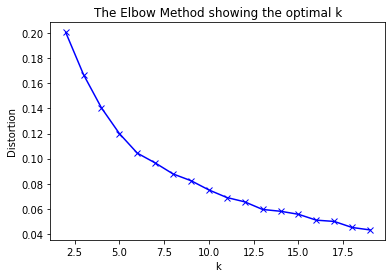

Cluster id labels for inputted data
[0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0
 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1
 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1]
Centroids data
[[-0.06919061 -0.12454014]
 [ 0.28312019  0.17417985]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-4.503322677344512
Silhouette_score: 
0.6479945796796676


In [129]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from scipy.spatial import distance

X=X
 
# k means determine k
distortions = []
K = range(2,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


k=2
kmeanModel = KMeans(n_clusters=k).fit(X)
kmeanModel.fit(X)
labels=kmeanModel.labels_
centroids=kmeanModel.cluster_centers_


print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeanModel.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='cosine')
 
print ("Silhouette_score: ")
print (silhouette_score)

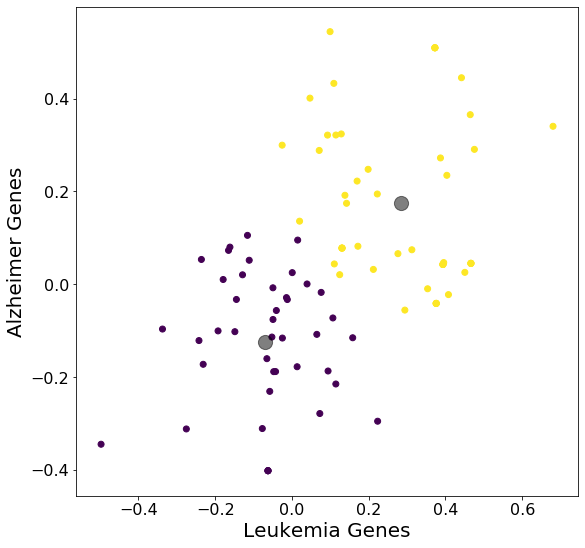

In [130]:
fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlabel('Leukemia Genes',fontsize=20)
ax.set_ylabel('Alzheimer Genes',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(X[:, 0], X[:, 1], c=labels,cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)


In [203]:
park=pd.DataFrame(score4).dropna()
alzz=pd.DataFrame(score).dropna()
apark=park.merge(alzz,on=0,how='inner')
apark=aleuk[apark[0]!='nan']
apark

/Users/maggie/python-data/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,0,1_x,1_y
9,mapt,0.148657,0.248537
10,rala,-0.027603,-0.216718
11,myc,0.103407,-0.003600
12,lep,0.183829,0.350887
13,saa1,0.109568,0.128410
...,...,...,...
93,braf,-0.055515,-0.009385
94,bdnf,0.061812,-0.124007
95,gstm1,-0.004810,-0.079512
96,hnf4a,-0.141188,0.297379


In [205]:
X=np.array(apark.iloc[:,1:])

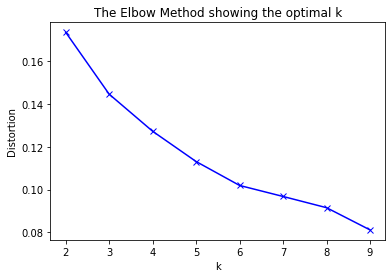

Cluster id labels for inputted data
[0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0
 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0]
Centroids data
[[ 0.15533105  0.19188071]
 [-0.01344433 -0.14299433]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-3.5239284189897977
Silhouette_score: 
0.6582630230208467


In [206]:

from sklearn import cluster
from sklearn import metrics
from scipy.spatial import distance

X=X
 
# k means determine k
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


k=2
kmeanModel = KMeans(n_clusters=k).fit(X)
kmeanModel.fit(X)
labels=kmeanModel.labels_
centroids=kmeanModel.cluster_centers_


print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeanModel.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='cosine')
 
print ("Silhouette_score: ")
print (silhouette_score)

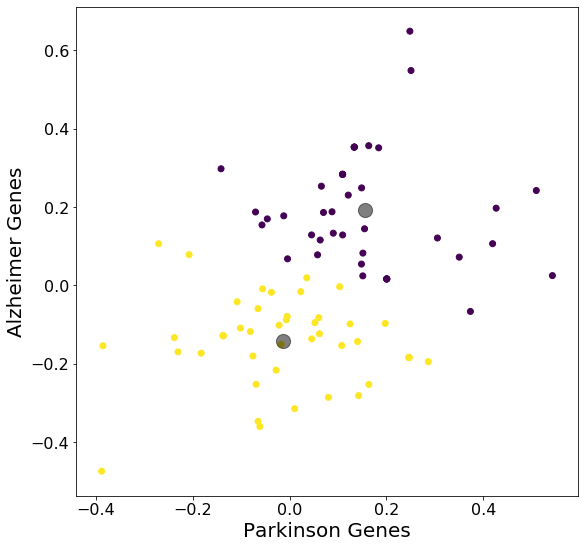

In [207]:
fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlabel('Parkinson Genes',fontsize=20)
ax.set_ylabel('Alzheimer Genes',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(X[:, 0], X[:, 1], c=labels,cmap='viridis')

plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)